# how do the results change if we had listened to random Ovenbird detections clips instead of used AIID?

what is the equivalent amount of effort that we did per point * visit?

In [1]:
from opensoundscape import Audio, Spectrogram, CNN, BoxedAnnotations

import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path

from matplotlib import pyplot as plt
def figsize(w,h):
    plt.rcParams['figure.figsize']=[w,h]
figsize(15,5) #for big visuals
%config InlineBackend.figure_format = 'retina'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# plt.rcParams['font.family'] = 'Gill Sans'

In [2]:
pam_dataset_path = "../../../pam_dataset_v4/"
clusters = pd.read_csv(
    f"{pam_dataset_path}/per_point_clusters.csv",
    index_col=0,
    parse_dates=["date", "datetime", "time"],
)

/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_2921/1881774826.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  clusters = pd.read_csv(


This analysis excludes any un-clustered detections since we don't know how many un-clustered individuals we may have found

In [3]:
clusters["year"] = clusters["date"].apply(lambda x: x.year)
# remove unclustered samples with -1 HDBSCAN label
clusters = clusters[~clusters["cluster_30"].str.contains("-1")]

In [ ]:
# detection history when all clusters are reviewed:
full_det_hist = clusters.groupby(["cluster_30", "year"]).size().unstack()
full_det_hist = (full_det_hist > 0).astype(int)
full_n_years_detected = full_det_hist.sum(1).value_counts()

full_det_hist.to_csv(
    "../../results/detection_histories/det_hists_with_random_sampling/full_det_hist.csv"
)

In [ ]:
# clusters.groupby(['per_point_cluster','year']).size()#.unstack().fillna(0).plot(kind='bar', stacked=True)
# simulation: if you listen to N random recordings from each point each year, how many clusters do you expect to hear?
# and what is the recapture history of an individual?
nyears_records = [
    {
        "method": "AIID clusters",
        1: full_n_years_detected[1],
        2: full_n_years_detected[2],
        3: full_n_years_detected[3],
        4: full_n_years_detected[4],
    }
]
nindividuals_records = [
    {"method": "AIID clusters", "n_individuals": len(full_det_hist)}
]
np.random.seed(2025)

for i in range(5):
    for n_review in [100, 50, 20, 10, 5, 2, 1]:
        # stratified random sample of n_review rows from each point each year
        sample = clusters.groupby(["year", "point_code"], group_keys=False).apply(
            lambda x: x.sample(min(len(x), n_review))
        )
        # detection history:

        sample_det_hist = sample.groupby(["cluster_30", "year"]).size().unstack()
        sample_det_hist = (sample_det_hist > 0).astype(int)
        sample_n_years_detected = sample_det_hist.sum(1).value_counts()
        sample_det_hist.to_csv(
            f"../../results/detection_histories/random_{n_review}_det_hist_{i}.csv"
        )

        nyears = sample_n_years_detected.to_dict()
        nyears.update({"method": f"Random {n_review} per point"})
        nyears_records.append(nyears)

        nindividuals_records.append(
            {
                "method": f"Random {n_review} per point",
                "n_individuals": len(sample["cluster_30"].unique()),
            }
        )
nyears_detected = pd.DataFrame(nyears_records).set_index("method")
nindividuals_detected = pd.DataFrame(nindividuals_records).set_index("method")

/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_2921/2877942846.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = clusters.groupby(["year", "point_code"], group_keys=False).apply(
/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_2921/2877942846.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = clusters.groupby(["year", "point_code"], group_keys=False).apply(
/var

In [8]:
nyears_long = (
    nyears_detected.stack()
    .reset_index()
    .rename(columns={"level_1": "n_years_detected", 0: "n_clusters"})
)

/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_2921/2484641492.py:6: UserWarning: The palette list has more values (9) than needed (8), which may not be intended.
  sns.lineplot(


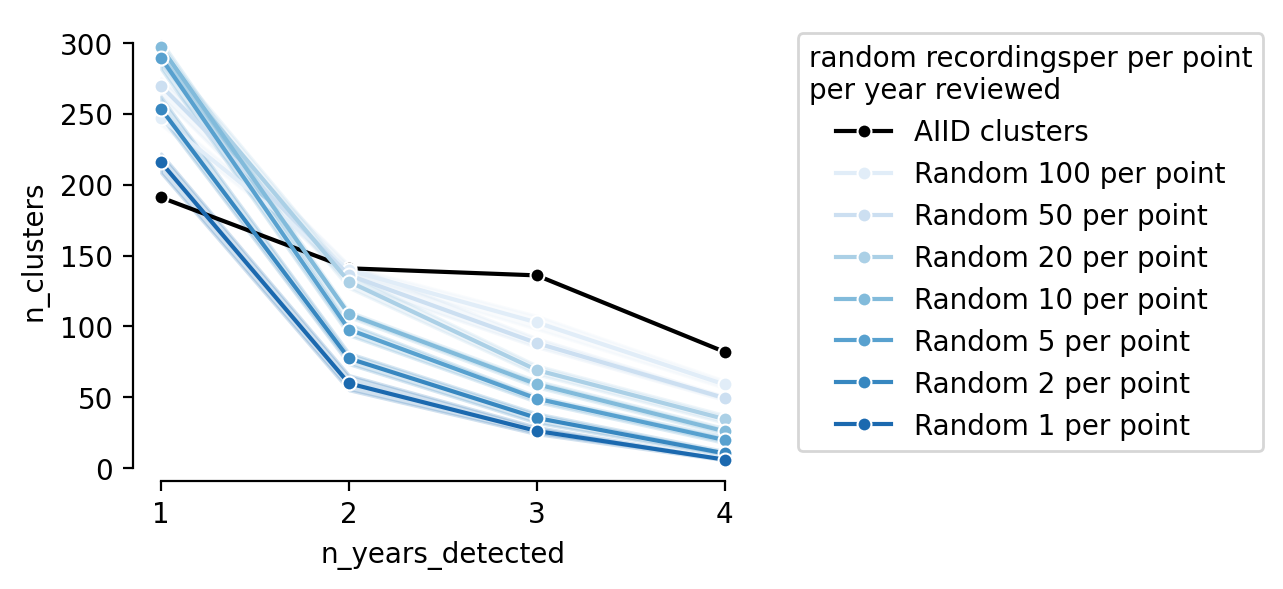

In [10]:
import seaborn as sns

figsize(4, 3)
palette = ["#000000"] + sns.color_palette(palette="Blues", n_colors=8)

sns.lineplot(
    nyears_long,
    x="n_years_detected",
    y="n_clusters",
    hue="method",
    errorbar=("ci", 95),
    palette=palette,
    marker="o",
    markersize=5,
)

plt.xticks([1, 2, 3, 4])
# move legend outside of plot
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    title="random recordingsper per point\nper year reviewed",
)

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
# trim x axis line to the first/last tick
plt.gca().spines["bottom"].set_bounds(1, 4)

plt.gca().spines["left"].set_bounds(0, 300)

plt.savefig("../../figures/random_sampling_n_years_detected.pdf")

In [11]:
print(
    f"Individuals found: {nindividuals_detected.groupby('method').n_individuals.mean()}"
)

Individuals found: method
AIID clusters           550.0
Random 1 per point      307.8
Random 10 per point     490.8
Random 100 per point    548.2
Random 2 per point      376.8
Random 20 per point     524.8
Random 5 per point      456.2
Random 50 per point     543.6
Name: n_individuals, dtype: float64


### simulation: if you listen to N random recordings from each point, how many clusters do you expect to hear?


In [12]:
# clusters.groupby(['per_point_cluster','year']).size()#.unstack().fillna(0).plot(kind='bar', stacked=True)
# simulation: if you listen to N random recordings from each point each year, how many clusters do you expect to hear?
# and what is the recapture history of an individual?
nindividuals_records = [
    {"method": "AIID clusters", "n_individuals": len(full_det_hist)}
]
np.random.seed(2025)

for i in range(5):
    for n_review in [100, 50, 20, 10, 5, 2, 1]:
        # stratified random sample of n_review rows from each point each year
        sample = clusters.groupby(["point_code"], group_keys=False).apply(
            lambda x: x.sample(min(len(x), n_review))
        )
        nindividuals_records.append(
            {
                "method": f"Random {n_review} per point",
                "n_reviewed": n_review,
                "n_individuals": len(sample["cluster_30"].unique()),
            }
        )
nindividuals_detected = pd.DataFrame(nindividuals_records).set_index("method")

/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_2921/4149212087.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = clusters.groupby(["point_code"], group_keys=False).apply(
/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_2921/4149212087.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = clusters.groupby(["point_code"], group_keys=False).apply(
/var/folders/d8/265w

In [13]:
nsites = len(clusters["point_code"].unique())
550 / nsites  # number of clusters per point

4.621848739495798

/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_2921/942907322.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


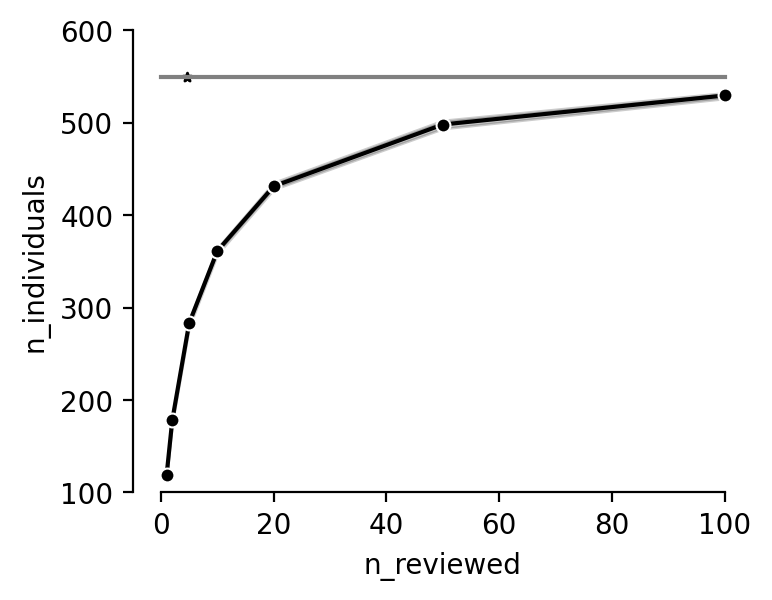

In [ ]:
import seaborn as sns

figsize(4, 3)
palette = ["#000000"] + sns.color_palette(palette="Blues", n_colors=8)

sns.lineplot(
    nindividuals_detected.dropna(),
    x="n_reviewed",
    y="n_individuals",
    palette=palette,
    marker="o",
    markersize=5,
    color="black",
)

plt.plot([0, 100], [550, 550], color="grey")  # , linestyle='--', linewidth=1.5)
plt.scatter(550 / nsites, 550, color="black", marker="*", s=10, label="AIID clusters")

plt.ylim(100, 600)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
# trim x axis line to the first/last tick
plt.gca().spines["bottom"].set_bounds(0, 100)
plt.gca().spines["left"].set_bounds(100, 600)

plt.savefig("../../figures/random_sampling_individual_discovery_curve.pdf")

I ran cjs survival model on each simulated detection history

/Users/SML161/miniconda3/envs/opso0110/lib/python3.11/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


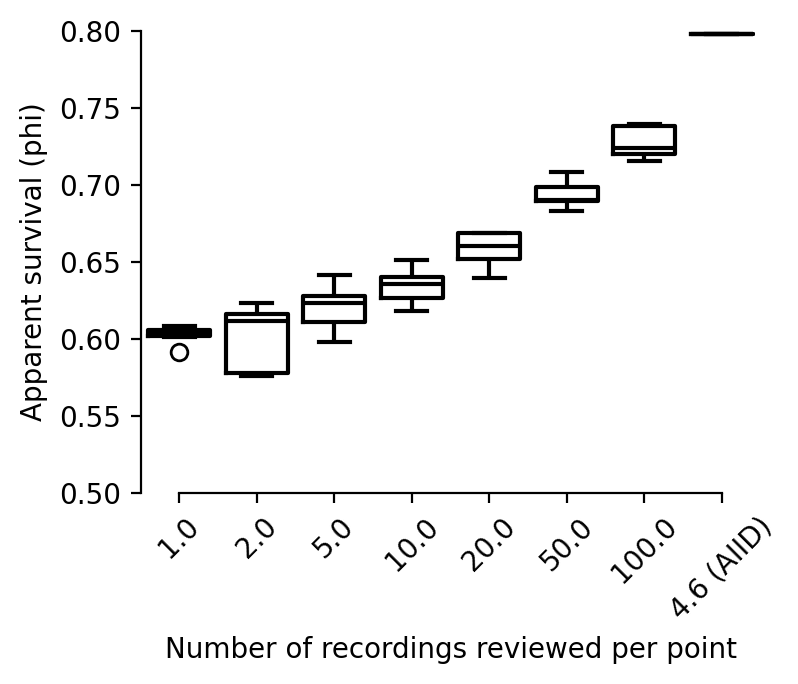

In [ ]:
cjs_results = pd.read_csv(
    "../../results/detection_histories/det_hists_with_random_sampling/all_cjs_summary_values.csv"
).sort_values(by="n_reviewed")
cjs_results["n_reviewed"] = cjs_results["n_reviewed"].fillna("4.6 (AIID)")
sns.boxplot(
    cjs_results, x="n_reviewed", y="phi", fill=None, color="black"
)  # marker='o', markersize=5)
# sns.boxplot(cjs_results, x='n_reviewed', y='p',fill=None)# marker='o', markersize=5)

plt.ylabel(None)
plt.xlabel("Number of recordings reviewed per point")
plt.xticks(rotation=45)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.ylim(0.5, 0.8)
plt.gca().spines["left"].set_bounds(0.5, 0.8)
plt.gca().spines["bottom"].set_bounds(0, 7)
# plt.gca().spines["bottom"].set_alpha
# plt.legend(['phi','p'])
plt.ylabel("Apparent survival (phi)")
plt.savefig("../../figures/random_sampling_cjs_phi.pdf", bbox_inches="tight")